In [18]:
import pandas as pd
import numpy as np
import os
#
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#
from sklearn.model_selection import train_test_split
#
from sklearn.metrics import accuracy_score
#
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
#
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

#from sklearn.externals import joblib
import spacy


class Text_Analytics:
    # Specification of training set is FEATURE and TARGET
    _stopwords_remove_ = False
    _test_split_size_  = 0.3
    _random_state_     = 111
    #
    _features_train_     = None
    _features_test_      = None
    _labels_train_       = None
    _labels_test_        = None
    #
    _training_set_       = pd.DataFrame()
    _test_set_           = None
    _implementation_set_ = None
    
    def __init__(self, train, FEATURE, TARGET, REFERENCE, implementation = None, test = None, frac = 0.8):
        
        self._training_set_ = self.read_excel_dataset(train, feature_column = FEATURE, target_column = TARGET, reference_column = REFERENCE)
        self.dataset_description()
        if(test != None):
            self._test_set_ = self.dataset_prepare(test, feature_column = FEATURE, target_column = TARGET)
        if(implementation != None):
            self._implementation_set_ = self.dataset_prepare(implementation, feature_column = FEATURE, reference_column = REFERENCE)
        
    def dataset_prepare(self, folder_path, feature_column=None, target_column=None, reference_column=None):
    
        input_csvs = os.listdir(folder_path)
        input_csvs = [f for f in input_csvs if ".csv" in f]
        print("Total " + str(len(input_csvs))+ " Files found in the location")
        input_df = pd.DataFrame()
        print("Reading files please wait...")
        for files in input_csvs:
            temp_df = pd.read_csv(folder_path+'//'+files, encoding = 'latin', engine='python')
            input_df = input_df.append(temp_df, ignore_index = True)
        input_df = input_df.dropna()
        print("Dimentions : ")
        print(input_df.shape)
        if(target_column != None):
            input_df = input_df.filter(items=[feature_column, target_column])
        elif(reference_column != None):
            input_df = input_df.filter(items=[reference_column, feature_column])
        print("Dimentions :           (Feature selection)")
        print(input_df.shape)
        input_df = input_df.dropna()
        print("Dimentions :           (na removal)")
        print(input_df.shape)
        input_df = input_df.drop_duplicates()
        print("Dimentions :           (Duplicates removal)")
        print(input_df.shape)
        print("Preprocessing text for the dataset\n")
        input_df[feature_column+"_preprocessed"] = input_df[feature_column].apply(lambda x: self.text_preprocess(x,stopwords_remove = False))
        input_df = input_df.replace(r'^\s*$', np.nan, regex=True)
        print("Dimentions :           (after preprocess)")
        print(input_df.shape)
        input_df = input_df.dropna()
        print("Dimentions :           (na removal)")
        print(input_df.shape)
        input_df = input_df.drop_duplicates()
        print("Dimentions :           (Duplicates removal)")
        print(input_df.shape)
        return input_df


    def text_preprocess(self,s,stopwords_remove = True):
        #    s = re.sub(r"@(\w+)", "mention", s)
        s = re.sub(r"http\S+", " ", s)
        s = re.sub(r"RT", " ", s)
        s = re.sub(r"QT", " ", s)
        s = re.sub(r"URL123PLH", " ", s)
        #    s = re.sub(r"#(\w+)", "hashtag", s)  
        s = re.sub(r"[^A-Za-z0-9:(),!?\'\`]", " ", s)
        s = re.sub("\d+", " ", s)
        s = re.sub(r"\b[a-zA-Z]\b", " ", s)
        s = re.sub(r"\'", " ", s)
        s = re.sub(r"\'s", " ", s)
        s = re.sub(r"\'ve", " ", s)
        s = re.sub(r"n\'t", " ", s)
        s = re.sub(r"\'re", " ", s)
        s = re.sub(r"\'d", " ", s)
        s = re.sub(r"\'ll", " ", s)
        s = re.sub(r",", " ", s)
        s = re.sub(r"!", " ", s)
        s = re.sub(r":", " ", s)
        s = re.sub(r"\+", " ", s)
        s = re.sub(r"-", " ", s)
        s = re.sub(r"_", " ", s)
        s = re.sub(r"\(", " ", s)
        s = re.sub(r"\)", " ", s)    
        s = re.sub(r"\\", " ", s)
        s = re.sub(r"\?", " ", s)    
        s = re.sub(r"\s{2,}", " ", s)   
        s = re.sub(r"''", " ", s)
        s = s.lower()

        if(stopwords_remove == True):

            stop_words = set(stopwords.words('english'))
            word_tokens = word_tokenize(s)
            s_temp = ''
            for word in word_tokens:
                if word not in stop_words:
                    s_temp = s_temp + word + ' '     

        return s.strip().lower()
    
    def read_excel_dataset(self, folder_path, feature_column, target_column=None, reference_column=None):

        reference_df = pd.DataFrame()
        categories = ["Skin","Haircolor","Haircare","Fragrance","Face","Tools","Men"]
        for cat in categories:
            reference_df = reference_df.append(pd.read_excel(folder_path,sheet_name=cat))
            reference_df = reference_df.dropna()
        print("Dimentions :            (Before cleaning)")
        print(reference_df.shape)
        reference_df = reference_df.filter(items=[reference_column, target_column, feature_column])
        print("Dimentions :            (After Feature Selection)")
        print(reference_df.shape)
        reference_df = reference_df.drop_duplicates()
        print("Dimentions :            (Duplicates removed)")
        print(reference_df.shape)
        reference_df[target_column] = reference_df[target_column].apply(lambda x: x.upper())
        reference_df[target_column] = reference_df[target_column].apply(lambda x: 'HAM' if (x != "SPAM") else 'SPAM')
        reference_df = reference_df.astype("str")
        reference_df['length'] = reference_df[feature_column].apply(len)
        print(reference_df['length'].describe())
        reference_df[feature_column] = reference_df[feature_column].apply(lambda x: self.text_preprocess(x,stopwords_remove = False))
        reference_df = reference_df.replace(r'^\s*$', np.nan, regex=True)
        print("Dimentions :            (Before cleaning)")
        print(reference_df.shape)
        reference_df = reference_df.dropna()
        print("Dimentions :            (After na removal)")
        print(reference_df.shape)
        reference_df = reference_df.drop_duplicates()
        print("Dimentions :            (Duplicates removed)")
        print(reference_df.shape)
        reference_df=reference_df.rename(columns = {target_column:'TARGET'})
        reference_df=reference_df.rename(columns = {feature_column:'FEATURE'})
        return reference_df
        
    def dataset_description(self):
        print('-' * 20 + 'Dataset (Head)' + '-' * 20)
        display(self._training_set_.head())
        
        print('-' * 20 + 'Dataset (Describe)' + '-' * 20)
        display(self._training_set_.describe())
        
        self._group_by_feature = self._training_set_.groupby('TARGET')
        print('-' * 20 + 'Groupby Class (Describe)' + '-' * 20)
        display(self._group_by_feature.describe())
        self.class_distribution()
        figure, axes = plt.subplots(1, 2, figsize=(15,5))
        n_words_in_context = self._training_set_['length'].values.tolist()
        self.plot_cdf(   
                         n_words_in_context, \
                         axes[0], \
                         xlim=[0, np.mean(n_words_in_context) + 3 * np.std(n_words_in_context) + 50],\
                         deltay = 0.05,\
                         ylim=[0, 1.00], xlabel='number of words'\
                     )
        self.plot_boxplot(self._training_set_, 'TARGET', 'length', axes[1])
        
    def vectorize_feature(df):
        textFeatures = df[feature_column].copy()
        #textFeatures = textFeatures.apply(pre_process)
        vectorizer = TfidfVectorizer("english")
        features = vectorizer.fit_transform(textFeatures)
        return features
        
    def train_test_partition():
        
        feature_matrix = vectorize_feature(self._training_set_)
        
        self._features_train_, self._features_test_, self._labels_train_, self._labels_test_ =\
                                                                        train_test_split(\
                                                                            feature_matrix,\
                                                                            self._training_set_['TARGET'],\
                                                                            test_size=self._test_split_size_,\
                                                                            random_state=self._random_state_\
                                                                            )
    
    def binary_classification():
        
        classifiers = ['NB', 'SVM', 'RFT']
        
        mnb = MultinomialNB(alpha=0.2)
        mnb.fit(features_train, labels_train)
        prediction = mnb.predict(features_test)
        accuracy_score(labels_test,prediction)
        
        svc = SVC(kernel='sigmoid', gamma=1.0)
        svc.fit(features_train, labels_train)
        prediction = svc.predict(features_test)
        accuracy_score(labels_test,prediction)
        
    def training_plots(self,hist_variable):
        acc = hist_variable.history['acc']
        val_acc = hist_variable.history['val_acc']
        loss = hist_variable.history['loss']
        val_loss = hist_variable.history['val_loss']
        epochs = range(len(acc))
        plt.plot(epochs, acc, '-', color='orange', label='training acc')
        plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.show()

        plt.plot(epochs, loss, '-', color='orange', label='training acc')
        plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        
    def class_distribution(self):
        df = self._training_set_
        x_features = df.columns.drop("TARGET")
        assert 0 < len(x_features)

        x_features = x_features[0]
        dist = df.groupby("TARGET")[x_features].size() / len(df)
        display(dist)        
        sns.barplot(x=dist.index, y=dist.values)
    
    def plot_boxplot(self, df, by, y, ax):
        ax = sns.boxplot(x=by, y=y, data=df[[by,  y]], ax = ax)
        ax.set_yscale('log')
    
    def plot_cdf(self,
         p, 
         ax, 
         deltax=None, 
         xlog=False, 
         xlim=[0, 1], 
         deltay=0.25, 
         ylog=False, 
         ylim=[0,1], 
         xlabel = 'x'):

        df = pd.DataFrame(p, columns=[xlabel])
        display(df.describe())
        
        ecdf = sm.distributions.ECDF(p)
        x = ecdf.x
        y = ecdf.y
        assert len(x) == len(y)
        if deltax is not None:
            x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
            ax.set_xticks(x_ticks)

        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim[0], xlim[1])
        ax.vlines(np.mean(p), min(y), max(y), color='red', label='mean', linewidth=2)
        ax.vlines(np.median(p), min(y), max(y), color='orange', label='median', linewidth=2)
        ax.vlines(np.mean(p) + 2 * np.std(p), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
        ax.vlines(np.mean(p) + 3 * np.std(p), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)

        y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
        ax.set_ylabel('CDF')
        ax.set_yticks(y_ticks)
        ax.set_ylim(ylim[0], ylim[1])

        if xlog is True:
            ax.set_xscale('log')

        if ylog is True:
            ax.set_yscale('log')


        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.9)

        ax.legend(loc=4)

        sns.set_style('whitegrid')
        sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax = ax)

In [19]:
class Binary_Classification(Text_Analytics):
    # There are 5 classifiers which is built
    # Naive Bayes
    # Support Vector Machines
    # Random Forest Tree
    # Deep Neural Network
    # Recurrent Neural Network
    
    __pipelines = None
    __params = {}
    __format_model_file_name = '{}_model.pkl'
    _nlp = spacy.load("en")

    def __init__(self, training_data, implementation_data, reference_column, feature_column = 'FEATURE', target_column = 'TARGET',frac=0.8):
    
        super(Binary_Classification, self).__init__(train = training_data, FEATURE = feature_column, REFERENCE = reference_column, TARGET = target_column, implementation = implementation_data)
        #self.__bow = CountVectorizer(analyzer=self.create_lemmas)
        #self.__tfidf = TfidfTransformer()
        
        #self.__svd = TruncatedSVD(n_components=50)
        self.__svd = SVC()

        self.__cv = StratifiedKFold(n_splits=10)
        
        self.__default_params = {
            'tfidf__use_idf': (True, False),
            'bow__analyzer': (self.create_lemmas, self.create_tokens),
        }
        print(self._training_set_.columns)
        print(super()._training_set_.columns)
        self.__X = self._training_set_['FEATURE'].values.tolist()
        self.__y = self._training_set_['TARGET'].values.tolist()
        self.__pipelines = {}
        
    def create_lemmas(self, c):
        tokens = self._nlp(c)
        return [token.lemma_ for token in tokens]
    
    def create_tokens(self, c):
        tokens = self._nlp(c)
        return [token for token in tokens]
        
   
    def __create_pipeline(self, option='NB'):
        if (option in self.__pipelines) is False:
                        
            if option is 'NB':
                #classifier = MultinomialNB()
                pipeline = Pipeline([
                    ('bow', CountVectorizer(analyzer=self.create_lemmas)),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', MultinomialNB()),
                ])

            elif option is 'SVM':
                #classifier = SVC()
                pipeline = Pipeline([
                    ('bow', CountVectorizer(analyzer=self.create_lemmas)),
                    ('tfidf', TfidfTransformer()),
                    ('svd', SVC()),
                    ('classifier', SVC()),
                ])
                
            elif option is 'RFT':
                classifier = RandomForestClassifier()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            else:
                classifier = MultinomialNB()

            self.__pipelines[option] = pipeline
            
            return pipeline

        else:
            return self.__pipelines[option]
            
            
    def __create_grid_search_params(self, option='NB'):
        
        if (option in self.__params) is False:
            if option is 'SVM':
                params = [
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__kernel': ['linear']
                    },
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__gamma': [0.001, 0.0001], 
                      'classifier__kernel': ['rbf']
                    }
                ]
                    #{
                    #  'classifier__C': [1, 10, 100, 1000], 
                    #  'classifier__gamma': [0.01, 0.1 , 1 ], 
                    #  'classifier__kernel': ['sigmoid']
                    #},
                # merging two list of paramaters on the same list.
#                 params = list(map(lambda m : {**m, **self.__default_params}, params))
            else:
                params = self.__default_params

            self.__params[option] = params
        else:
            params = self.__params[option]
            
        return params

        
        
    def validate(self, option='NB'):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:            
            scores = cross_val_score(pipeline, 
                                     self.__X, 
                                     self.__y, 
                                     scoring='accuracy', 
                                     cv=self.__cv,
                                     verbose=1)

            print('scores={}\nmean={} std={}'.format(scores, scores.mean(), scores.std()))
        else:
            print ("pipeline does not exist!")

        
    def train(self, option='NB', dump=True):
        
        pipeline = self.__create_pipeline(option)
        print(pipeline)
        if pipeline is not None:
            
            params = self.__create_grid_search_params(option)
            
            grid = GridSearchCV(
                pipeline, 
                params, 
                refit=True, 
                n_jobs=-1, 
                scoring='accuracy', 
                cv=self.__cv)

            model = grid.fit(self.__X, self.__y)
            
            display('(Grid Search) Best Parameters:', )
            display(pd.DataFrame([model.best_params_]))

            if dump:
                model_file_name = self.__format_model_file_name.format(option)
                Util.dump_pickle(model, model_file_name)
                
            return model
                
        else:
            print('pipeline does not exist!')
            return None

    
    def test(self, X=None, model=None, model_file=None):
        
        if X is None:
            X = self.__X
        
        if model is None and model_file is None:
            print('Please, use either model or model_file')
            return []
        
        if model_file is not None and os.path.isfile(model_file):
            model = Util.load_pickle(model_file)
            print('{} file was loaded'.format(model_file))
            return model.predict(X)
        
        if model is not None:
            return model.predict(X)
        else:
            return []

Dimentions :            (Before cleaning)
(18676, 20)
Dimentions :            (After Feature Selection)
(18676, 3)
Dimentions :            (Duplicates removed)
(11440, 3)
count    11440.000000
mean        84.341521
std         50.135396
min          1.000000
25%         38.000000
50%         80.000000
75%        133.000000
max        239.000000
Name: length, dtype: float64
Dimentions :            (Before cleaning)
(11440, 4)
Dimentions :            (After na removal)
(10927, 4)
Dimentions :            (Duplicates removed)
(10927, 4)
--------------------Dataset (Head)--------------------


,HANDLES,TARGET,FEATURE,length
0,HealthFitnessP,SPAM,health fitness motivation club,32
1,nutralift2,SPAM,award winning premium natural organic skincare...,130
3,LivingOnChi,SPAM,fukushima and geoengineering are accelerating ...,152
4,LaydenRobinson,SPAM,composer of music horror bizarro fantasy ficti...,152
5,thebrittanyxoxo,HAM,just stardust soul looking for more sexy inter...,98


--------------------Dataset (Describe)--------------------


,length
count,10927.000000
mean,86.696532
std,49.574170
min,2.000000
25%,40.000000
50%,84.000000
75%,135.000000
max,239.000000


--------------------Groupby Class (Describe)--------------------


length                                                     
         count       mean        std  min   25%   50%    75%    max
TARGET                                                             
HAM     9292.0  87.082652  49.739029  3.0  40.0  85.0  136.0  239.0
SPAM    1635.0  84.502141  48.583338  2.0  40.0  82.0  130.0  231.0

TARGET
HAM     0.850371
SPAM    0.149629
Name: HANDLES, dtype: float64

,number of words
count,10927.000000
mean,86.696532
std,49.574170
min,2.000000
25%,40.000000
50%,84.000000
75%,135.000000
max,239.000000


Total 10 Files found in the location
Reading files please wait...
Dimentions : 
(364895, 15)
Dimentions :           (Feature selection)
(364895, 2)
Dimentions :           (na removal)
(364895, 2)
Dimentions :           (Duplicates removal)
(219595, 2)
Preprocessing text for the dataset

Dimentions :           (after preprocess)
(219595, 3)
Dimentions :           (na removal)
(210202, 3)
Dimentions :           (Duplicates removal)
(210202, 3)
Index(['HANDLES', 'TARGET', 'FEATURE', 'length'], dtype='object')
Index([], dtype='object')


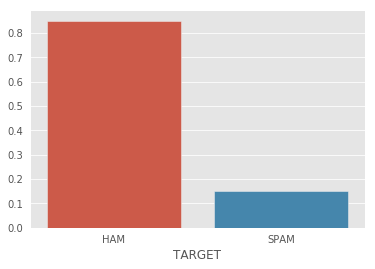

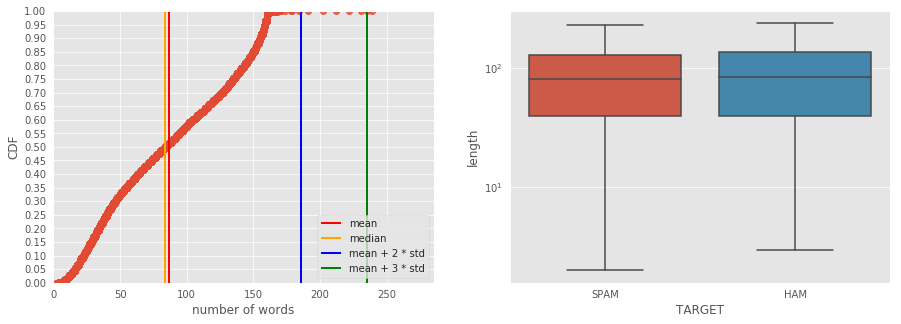

In [20]:
BC = Binary_Classification(training_data = ".//Twitter_Influencer_Spam_ID//Inputs//Final_list_10.8_10percentile_v3.xlsx",
                    feature_column = "PROFILE_INFO",
                    reference_column = "HANDLES",
                    target_column = "Spam/Ham",
                    implementation_data = ".//Twitter_Influencer_Spam_ID//Inputs")

In [21]:
classifiers = ['NB']

In [22]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time BC.validate(c)

'----------------------------------------NB----------------------------------------'

ValueError: n_jobs == 0 in Parallel has no meaning

In [ ]:
models = {}

for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time models[c] = BC.train(c)